In [19]:
import dask.dataframe as dd
df = dd.read_parquet('s3://iot-dest-bucket/data2023/11/19/14/*.parquet')


#converting dask df to pandas df 
df = df.compute()
df.to_csv('output.csv')

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score, precision_score, recall_score, f1_score
import lightgbm as lgb
import time

In [12]:
# Import the online learning metrics and algorithms from the River library
from river import metrics
from river import stream
from river import tree,neighbors,naive_bayes,ensemble,linear_model
from river.drift import DDM, ADWIN

# Define a generic adaptive learning function
# The argument "model" means an online adaptive learning algorithm
def adaptive_learning(model, X_train, y_train, X_test, y_test,name):
    metric = metrics.Accuracy() # Use accuracy as the metric
    i = 0 # count the number of evaluated data points
    t = [] # record the number of evaluated data points
    m = [] # record the real-time accuracy
    yt = [] # record all the true labels of the test set
    yp = [] # record all the predicted labels of the test set

    # Learn the training set
    for xi1, yi1 in stream.iter_pandas(X_train, y_train):
        model.learn_one(xi1,yi1) 

    # Predict the test set
    for xi, yi in stream.iter_pandas(X_test, y_test):
        y_pred= model.predict_one(xi)  # Predict the test sample
        model.learn_one(xi,yi) # Learn the test sample
        metric = metric.update(yi, y_pred) # Update the real-time accuracy
        t.append(i)
        m.append(metric.get()*100)
        yt.append(yi)
        yp.append(y_pred)
        i = i+1
        
    print(name + ":")
    print("Accuracy: "+str(round(accuracy_score(yt,yp),4)*100)+"%")
    print("Precision: "+str(round(precision_score(yt,yp),4)*100)+"%")
    print("Recall: "+str(round(recall_score(yt,yp),4)*100)+"%")
    print("F1-score: "+str(round(f1_score(yt,yp),4)*100)+"%")
    return t, m

### Base model learning

In [22]:
# Define a figure function that shows the real-time accuracy changes
def acc_fig(t, m, name):
    plt.rcParams.update({'font.size': 15})
    plt.figure(1,figsize=(10,6)) 
    sns.set_style("darkgrid")
    plt.clf() 
    plt.plot(t,m,'-b',label='Avg Accuracy: %.2f%%'%(m[-1]))

    plt.legend(loc='best')
    plt.title(name+' on IoTID20 dataset', fontsize=15)
    plt.xlabel('Number of samples')
    plt.ylabel('Accuracy (%)')

    plt.draw()   

In [21]:
# Define the Performance Weighted Probability Averaging Ensemble (PWPAE) model
def PWPAE(X_train, y_train, X_test, y_test):
    # Record the real-time accuracy of PWPAE and 4 base learners
    metric = metrics.Accuracy()
    metric1 = metrics.Accuracy()
    metric2 = metrics.Accuracy()
    metric3 = metrics.Accuracy()
    metric4 = metrics.Accuracy()

    i=0
    t = []
    m = []
    m1 = []
    m2 = []
    m3 = []
    m4 = []
    yt = []
    yp = []

    hat1 = ensemble.AdaptiveRandomForestClassifier(n_models=3) # ARF-ADWIN
    hat2 = ensemble.SRPClassifier(n_models=3) # SRP-ADWIN
    hat3 = ensemble.AdaptiveRandomForestClassifier(n_models=3,drift_detector=DDM(),warning_detector=DDM()) # ARF-DDM
    hat4 = ensemble.SRPClassifier(n_models=3,drift_detector=DDM(),warning_detector=DDM()) # SRP-DDM

    # The four base learners learn the training set
    for xi1, yi1 in stream.iter_pandas(X_train, y_train):
        hat1.learn_one(xi1,yi1)
        hat2.learn_one(xi1,yi1)
        hat3.learn_one(xi1,yi1)
        hat4.learn_one(xi1,yi1)

    # Predict the test set
    for xi, yi in stream.iter_pandas(X_test, y_test):
        # The four base learner predict the labels
        y_pred1= hat1.predict_one(xi) 
        y_prob1= hat1.predict_proba_one(xi) 
        hat1.learn_one(xi,yi)

        y_pred2= hat2.predict_one(xi) 
        y_prob2= hat2.predict_proba_one(xi)
        hat2.learn_one(xi,yi)

        y_pred3= hat3.predict_one(xi) 
        y_prob3= hat3.predict_proba_one(xi)
        hat3.learn_one(xi,yi)

        y_pred4= hat4.predict_one(xi) 
        y_prob4= hat4.predict_proba_one(xi)
        hat4.learn_one(xi,yi)
        
        # Record their real-time accuracy
        metric1 = metric1.update(yi, y_pred1)
        metric2 = metric2.update(yi, y_pred2)
        metric3 = metric3.update(yi, y_pred3)
        metric4 = metric4.update(yi, y_pred4)    

        # Calculate the real-time error rates of four base learners
        e1 = 1-metric1.get()
        e2 = 1-metric2.get()
        e3 = 1-metric3.get()
        e4 = 1-metric4.get()

        
        ep = 0.001 # The epsilon used to avoid dividing by 0
        # Calculate the weight of each base learner by the reciprocal of its real-time error rate
        ea = 1/(e1+ep)+1/(e2+ep)+1/(e3+ep)+1/(e4+ep)
        w1 = 1/(e1+ep)/ea
        w2 = 1/(e2+ep)/ea
        w3 = 1/(e3+ep)/ea
        w4 = 1/(e4+ep)/ea

        # Make ensemble predictions by the classification probabilities
        if  y_pred1 == 1:
            ypro10=1-y_prob1[1]
            ypro11=y_prob1[1]
        else:
            ypro10=y_prob1[0]
            ypro11=1-y_prob1[0]
        if  y_pred2 == 1:
            ypro20=1-y_prob2[1]
            ypro21=y_prob2[1]
        else:
            ypro20=y_prob2[0]
            ypro21=1-y_prob2[0]
        if  y_pred3 == 1:
            ypro30=1-y_prob3[1]
            ypro31=y_prob3[1]
        else:
            ypro30=y_prob3[0]
            ypro31=1-y_prob3[0]
        if  y_pred4 == 1:
            ypro40=1-y_prob4[1]
            ypro41=y_prob4[1]
        else:
            ypro40=y_prob4[0]
            ypro41=1-y_prob4[0]        

        # Calculate the final probabilities of classes 0 & 1 to make predictions
        y_prob_0 = w1*ypro10+w2*ypro20+w3*ypro30+w4*ypro40
        y_prob_1 = w1*ypro11+w2*ypro21+w3*ypro31+w4*ypro41

        if (y_prob_0>y_prob_1):
            y_pred = 0
            y_prob = y_prob_0
        else:
            y_pred = 1
            y_prob = y_prob_1
        
        # Update the real-time accuracy of the ensemble model
        metric = metric.update(yi, y_pred)

        t.append(i)
        m.append(metric.get()*100)
        yt.append(yi)
        yp.append(y_pred)
        
        i=i+1
        
    print("PWPAE:")
    print("Accuracy: "+str(round(accuracy_score(yt,yp),4)*100)+"%")
    print("Precision: "+str(round(precision_score(yt,yp),4)*100)+"%")
    print("Recall: "+str(round(recall_score(yt,yp),4)*100)+"%")
    print("F1-score: "+str(round(f1_score(yt,yp),4)*100)+"%")
    return t, m

In [23]:
from river import ensemble, metrics, drift, stream
from river.tree import HoeffdingTreeClassifier
from river.ensemble import AdaptiveRandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

def ACE(X_train, y_train, X_test, y_test):
    # Record the real-time accuracy of PWPAE and 4 base learners
    metric = metrics.Accuracy()
    metric1 = metrics.Accuracy()
    metric2 = metrics.Accuracy()
    metric3 = metrics.Accuracy()
    metric4 = metrics.Accuracy()

    i = 0
    t = []
    m = []
    m1 = []
    m2 = []
    m3 = []
    m4 = []
    yt = []
    yp = []

    # Define the base learners
    hat1 = AdaptiveRandomForestClassifier(n_models=3)  # ARF-ADWIN
    hat2 = ensemble.SRPClassifier(n_models=3)  # SRP-ADWIN
    hat3 = AdaptiveRandomForestClassifier(n_models=3, drift_detector=drift.DDM(), warning_detector=drift.DDM())  # ARF-DDM
    hat4 = ensemble.SRPClassifier(n_models=3, drift_detector=drift.DDM(), warning_detector=drift.DDM())  # SRP-DDM
    hat5 = XGBClassifier()  # XGBoost

    # Function to check for drift and retrain XGBoost if needed
    def check_and_retrain_xgboost():
        nonlocal hat5
        in_drift1, in_warning1 = hat3.drift_detector.update(metric3.get())
        in_drift2, in_warning2 = hat4.drift_detector.update(metric4.get())

        if in_drift1 or in_drift2:
            # Retrain XGBoost on recent data
            X_recent, y_recent = np.array(recent_data['X']), np.array(recent_data['y'])
            hat5.fit(X_recent, y_recent)

    # Initialize a buffer for recent data to retrain XGBoost
    recent_data = {'X': [], 'y': []}
    recent_data_size = 500  # Adjust the size based on your data and requirements

    # Train the base learners
    for xi1, yi1 in stream.iter_pandas(X_train, y_train):
        hat1.learn_one(xi1, yi1)
        hat2.learn_one(xi1, yi1)
        hat3.learn_one(xi1, yi1)
        hat4.learn_one(xi1, yi1)

        # Add to recent data buffer and maintain its size
        recent_data['X'].append(xi1)
        recent_data['y'].append(yi1)
        if len(recent_data['X']) > recent_data_size:
            recent_data['X'].pop(0)
            recent_data['y'].pop(0)

    # Retrain XGBoost initially on all training data
    hat5.fit(np.array(X_train), np.array(y_train))

    # Predict the test set
    for xi, yi in stream.iter_pandas(X_test, y_test):
        xi_array = np.array(list(xi.values())).reshape(1, -1)
        
        # Predictions from online learning models
        y_pred1 = hat1.predict_one(xi)
        y_prob1 = hat1.predict_proba_one(xi)
        hat1.learn_one(xi, yi)

        y_pred2 = hat2.predict_one(xi)
        y_prob2 = hat2.predict_proba_one(xi)
        hat2.learn_one(xi, yi)

        y_pred3 = hat3.predict_one(xi)
        y_prob3 = hat3.predict_proba_one(xi)
        hat3.learn_one(xi, yi)

        y_pred4 = hat4.predict_one(xi)
        y_prob4 = hat4.predict_proba_one(xi)
        hat4.learn_one(xi, yi)
        
        # Prediction from XGBoost
        y_pred5 = hat5.predict(xi_array)[0]
        y_prob5 = hat5.predict_proba(xi_array)[0]

        # Record their real-time accuracy
        metric1 = metric1.update(yi, y_pred1)
        metric2 = metric2.update(yi, y_pred2)
        metric3 = metric3.update(yi, y_pred3)
        metric4 = metric4.update(yi, y_pred4)    

        # Calculate the real-time error rates of the base learners
        e1 = 1 - metric1.get()
        e2 = 1 - metric2.get()
        e3 = 1 - metric3.get()
        e4 = 1 - metric4.get()

        ep = 0.001  # The epsilon used to avoid dividing by 0
        # Calculate the weight of each base learner by the reciprocal of its real-time error rate
        ea = 1 / (e1 + ep) + 1 / (e2 + ep) + 1 / (e3 + ep) + 1 / (e4 + ep)
        w1 = 1 / (e1 + ep) / ea
        w2 = 1 / (e2 + ep) / ea
        w3 = 1 / (e3 + ep) / ea
        w4 = 1 / (e4 + ep) / ea

        # Calculate the final probabilities of classes 0 & 1 to make predictions
        y_prob_0 = w1 * y_prob1.get(0, 0) + w2 * y_prob2.get(0, 0) + w3 * y_prob3.get(0, 0) + w4 * y_prob4.get(0, 0)
        y_prob_1 = w1 * y_prob1.get(1, 0) + w2 * y_prob2.get(1, 0) + w3 * y_prob3.get(1, 0) + w4 * y_prob4.get(1, 0)

        y_pred = 0 if y_prob_0 > y_prob_1 else 1
        
        # Update the real-time accuracy of the ensemble model
        metric = metric.update(yi, y_pred)

        t.append(i)
        m.append(metric.get() * 100)
        yt.append(yi)
        yp.append(y_pred)
        
        i += 1

        # Check for drift and potentially retrain XGBoost
        check_and_retrain_xgboost()

    # Performance evaluation and print statements
    print("ACE:")
    print("Accuracy: " + str(round(accuracy_score(yt, yp), 4) * 100) + "%")
    print("Precision: " + str(round(precision_score(yt, yp), 4) * 100) + "%")
    print("Recall: " + str(round(recall_score(yt, yp), 4) * 100) + "%")
    print("F1-score: " + str(round(f1_score(yt, yp), 4) * 100) + "%")
    
    return t, m

# Example usage
# t, m = PWPAE(X_train_data, y_train_data, X_test_data, y_test_data)


ACE:
Accuracy: 99.11%
Precision: 99.1%
Recall: 99.96000000000001%
F1-score: 99.53%


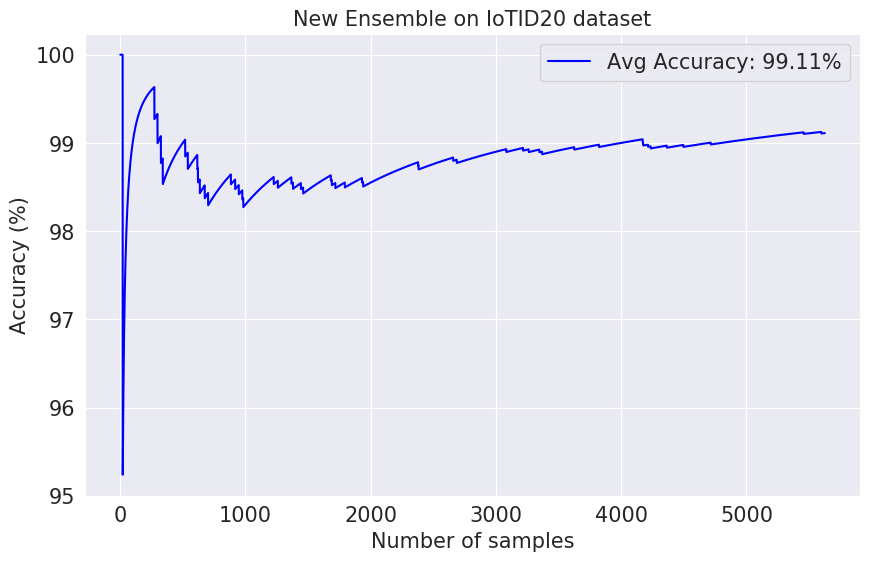

In [16]:
%matplotlib inline

name = "New Ensemble"
t, m9 = ACE(X_train, y_train, X_test, y_test)
acc_fig(t, m9, name)

In [17]:
import dask.dataframe as dd
import time
%matplotlib inline

#while(True):
#df = dd.read_parquet('s3://iot-dest-bucket/data2023/11/28/14/*.parquet').compute()
#df = pd.read_csv("IoT_2020_b_0.01_fs.csv")
df = pd.read_csv("IoT_2020_b_0.01_fs.csv")
X = df.drop(['Label'],axis=1)
y = df['Label']
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.1, test_size = 0.9, shuffle=False,random_state = 0)

# Use the Adaptive Random Forest (ARF) model with ADWIN drift detector
name1 = "ARF-ADWIN model"
model1 = ensemble.AdaptiveRandomForestClassifier(n_models = 3, drift_detector = ADWIN()) # Define the model
t, m1 = adaptive_learning(model1, X_train, y_train, X_test, y_test, name1) # Learn the model on the dataset

# Use the Adaptive Random Forest (ARF) model with DDM drift detector
name2 = "ARF-DDM model"
model2 = ensemble.AdaptiveRandomForestClassifier(n_models = 3, drift_detector = DDM()) # Define the model
t, m2 = adaptive_learning(model2, X_train, y_train, X_test, y_test, name2) # Learn the model on the dataset

# Use the Hoeffding Tree (HT) model 
name6 = "HT model"
model6 = tree.HoeffdingTreeClassifier() # Define the model
t, m6 = adaptive_learning(model6, X_train, y_train, X_test, y_test, name6) # Learn the model on the dataset

# Use the Leveraging Bagging (LB) model 
name7 = "LB model"
model7 = ensemble.LeveragingBaggingClassifier(model=tree.HoeffdingTreeClassifier(),n_models=3) # Define the model
t, m7 = adaptive_learning(model7, X_train, y_train, X_test, y_test, name7) # Learn the model on the dataset

# Use the Performance Weighted Probability Averaging Ensemble (PWPAE) model 
name5 = "Proposed PWPAE model"
t, m5 = PWPAE(X_train, y_train, X_test, y_test) # Learn the model on the dataset

#New Ensemble
name = "New Ensemble"
t, m = ACE(X_train, y_train, X_test, y_test)

#time.sleep(60)

ARF-ADWIN model:
Accuracy: 98.37%
Precision: 98.55000000000001%
Recall: 99.74%
F1-score: 99.14%
ARF-DDM model:
Accuracy: 98.28%
Precision: 98.4%
Recall: 99.79%
F1-score: 99.09%
HT model:
Accuracy: 95.45%
Precision: 95.91%
Recall: 99.42%
F1-score: 97.63%
LB model:
Accuracy: 97.46000000000001%
Precision: 98.05%
Recall: 99.28%
F1-score: 98.66%
PWPAE:
Accuracy: 98.95%
Precision: 99.00999999999999%
Recall: 99.89%
F1-score: 99.45%
ACE:
Accuracy: 99.03999999999999%
Precision: 99.08%
Recall: 99.91%
F1-score: 99.49%


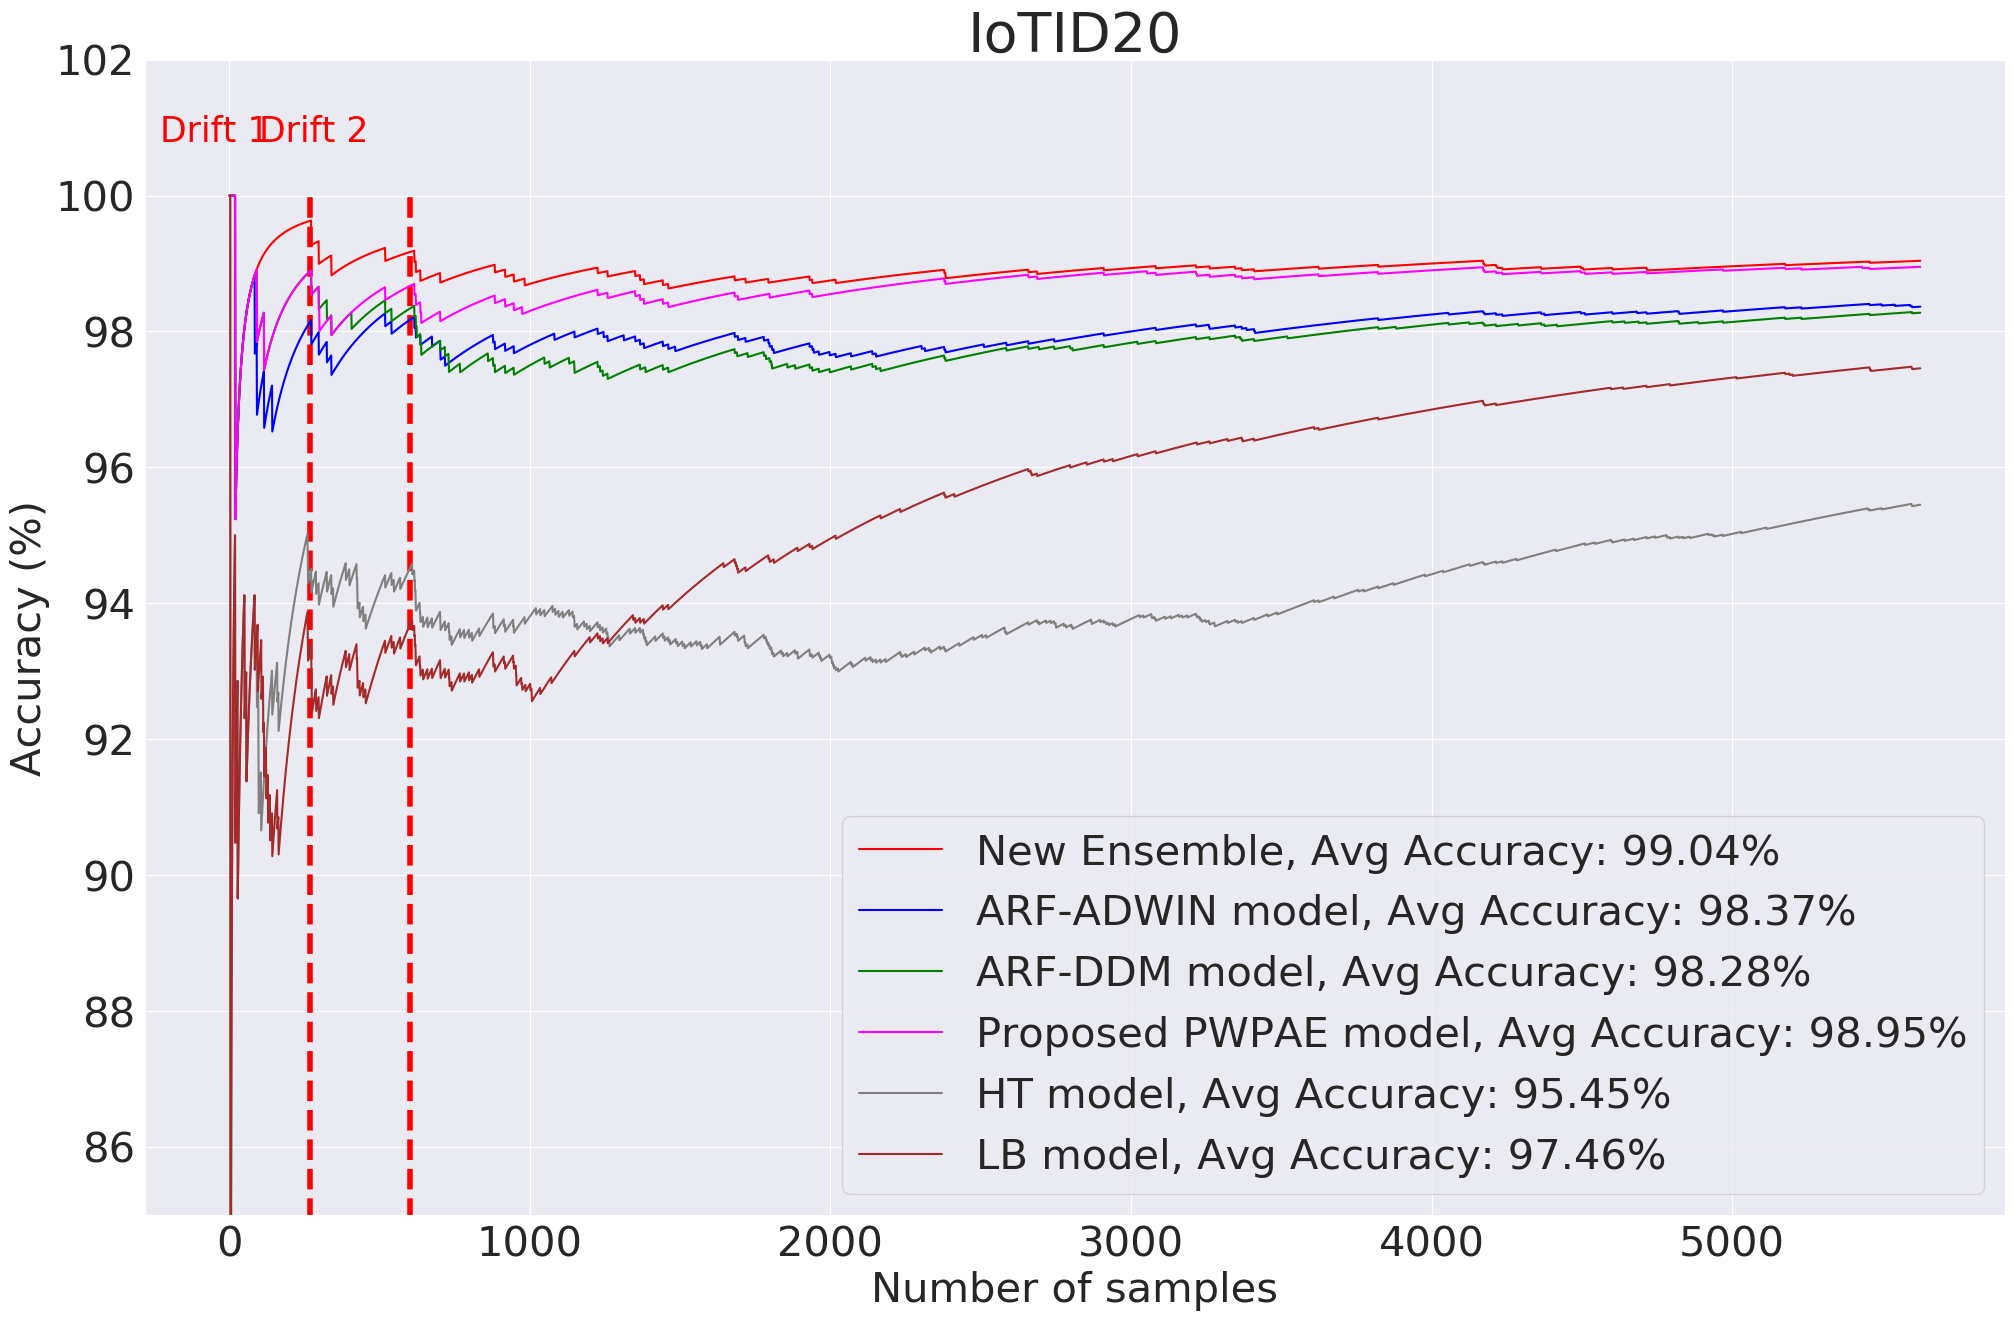

In [18]:
    # Draw a comprehensive figure to compare the performance of all models
    plt.rcParams.update({'font.size': 30})
    plt.figure(1,figsize=(24,15)) 
    sns.set_style("darkgrid")
    plt.clf() 

    # Plot the accuracy change of each learner
    plt.plot(t,m,'-r',label=name+', Avg Accuracy: %.2f%%'%(m[-1]))
    plt.plot(t,m1,'-b',label=name1+', Avg Accuracy: %.2f%%'%(m1[-1]))
    plt.plot(t,m2,'-g',label=name2+', Avg Accuracy: %.2f%%'%(m2[-1]))
    #plt.plot(t,m3,'orange',label=name3+', Avg Accuracy: %.2f%%'%(m3[-1]))
    #plt.plot(t,m4,'black',label=name4+', Avg Accuracy: %.2f%%'%(m4[-1]))
    plt.plot(t,m5,'magenta',label=name5+', Avg Accuracy: %.2f%%'%(m5[-1]))
    plt.plot(t,m6,'grey',label=name6+', Avg Accuracy: %.2f%%'%(m6[-1]))
    plt.plot(t,m7,'brown',label=name7+', Avg Accuracy: %.2f%%'%(m7[-1]))

    # Draw the drift points/time
    dr = [0,270,600]
    for i in range(len(dr)):
        if i!=0:
            plt.text(dr[i]-500, 100.8, 'Drift '+str(i), c = "red", fontsize = 25)
            plt.vlines(dr[i], 0, 100, colors = "red", linewidth=4, linestyles = "dashed")

    plt.legend(loc='lower right')
    plt.ylim(85, 102)
    plt.title('IoTID20', fontsize=40)
    plt.xlabel('Number of samples')
    plt.ylabel('Accuracy (%)')

    plt.draw()